# 데이터 불러오기

In [105]:
import yfinance as yf
TSLA = yf.download("TSLA", start="2019-01-01", end="2023-03-31")
TSLA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


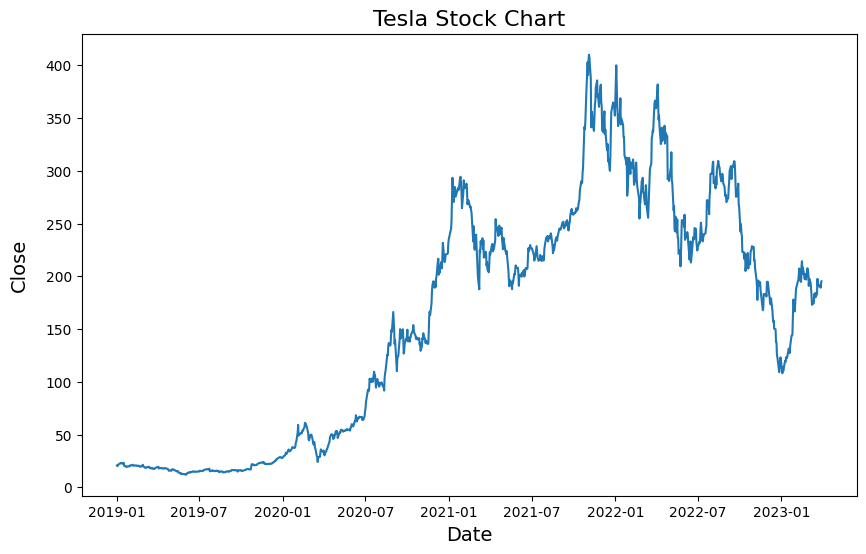

In [106]:
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=TSLA, x=TSLA.index, y=TSLA.Close, ax=ax)
ax.set_title('Tesla Stock Chart', size = 16)
ax.set_xlabel('Date', size = 14)
ax.set_ylabel('Close', size = 14, labelpad=12)
ax.yaxis.set_major_formatter(formatter)

plt.savefig('output/scikit-learn01.png', dpi=200)
plt.show()

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings("ignore")

def tsplot(y, lags=None, figsize=(10, 6), tickerName = "stock", outputname = 'output/scikit-learn.png'):
    """시계열 그래프, ACF, PACF, Dickey–Fuller test 계산한다. 
    Parameters:
        y : 시계열 데이터
        lags : ACF, PACF, Dickey-Fuller 검정
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    p_value = np.round(sm.tsa.stattools.adfuller(y)[1], 3)

    fig = plt.figure(figsize=figsize)
    layout = (0.5, 0.5)

    spec = fig.add_gridspec(nrows=2, ncols=2, height_ratios=layout, width_ratios=layout)

    ### 2. setting axes
    axs = {}
    for i in range(len(layout)*len(layout)):
        if i >= 2:
            axs[i] = fig.add_subplot(spec[i//len(layout), i%len(layout)])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})
        else:
            axs[i] = fig.add_subplot(spec[i//len(layout), :])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})

    fig.delaxes(axs[0])

    axs[1].plot(y)
    axs[1].set_title(f'{tickerName} Stock Time Series Analysis Plots\n Dickey-Fuller: p={p_value}')

    smt.graphics.plot_acf(y, lags=lags, ax=axs[2])
    axs[2].set_ylim(-1.5, 1.5)
    axs[2].set_title('Autocorrelation')
    smt.graphics.plot_pacf(y, lags=lags, ax=axs[3])
    
    axs[3].set_ylim(-1.5, 1.5)
    axs[3].set_title('Partial Autocorrelation')

    fig.tight_layout()
    plt.savefig(outputname, dpi=200)
    plt.show()

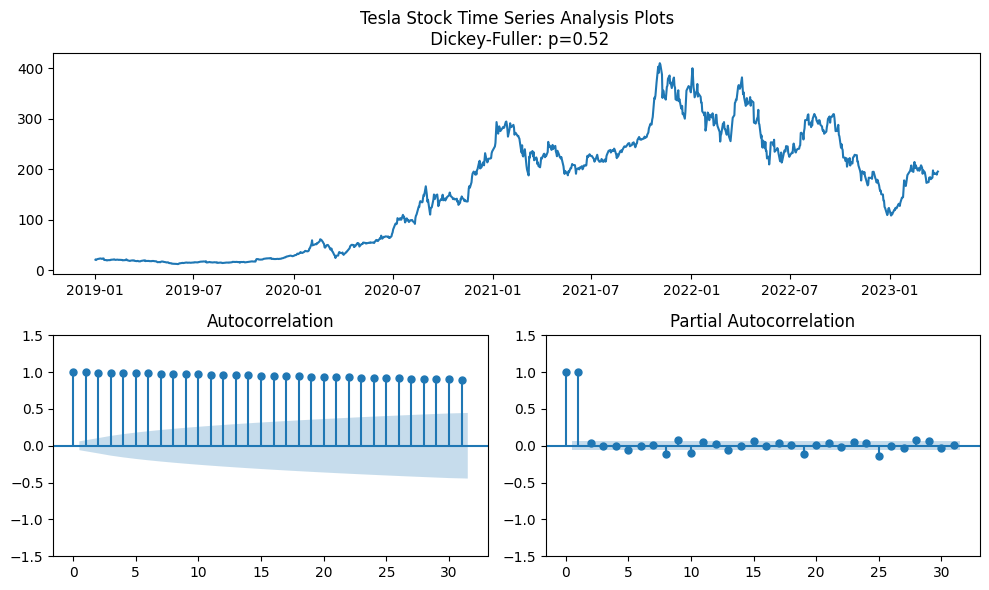

In [108]:
tsplot(TSLA.Close, tickerName = "Tesla", outputname = 'output/scikit-learn02.png')

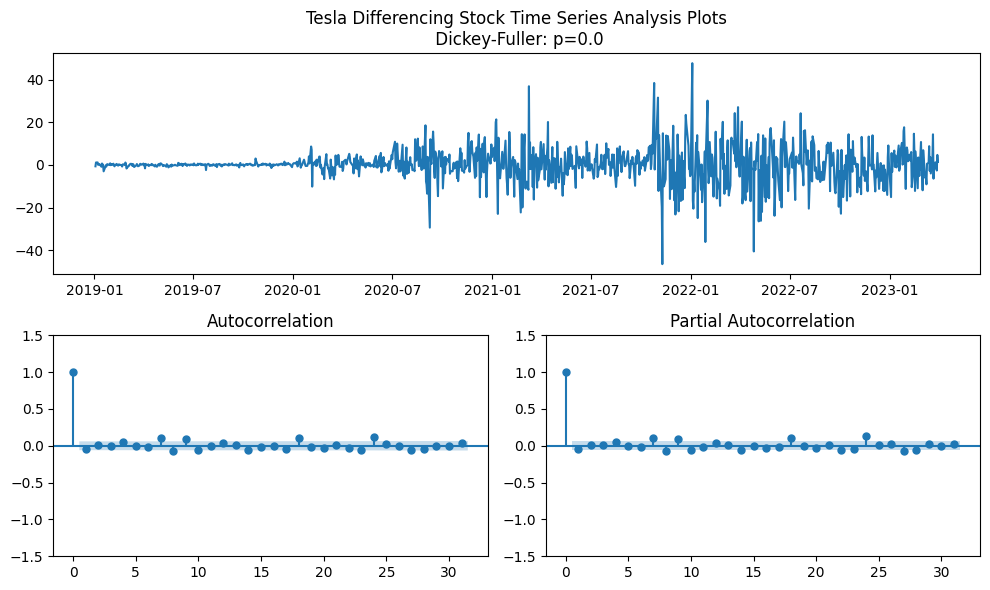

In [109]:
ts_sun_diff = (TSLA.Close - TSLA.Close.shift(1)).dropna()
tsplot(ts_sun_diff, tickerName = "Tesla Differencing", outputname = 'output/scikit-learn03.png')

In [110]:
test_len = int(len(TSLA.Close) * 0.2)
TSLA_train, TSLA_test = TSLA.Close.iloc[:-test_len], TSLA.Close.iloc[-test_len:]
TSLA_train.shape, TSLA_test.shape

((856,), (213,))

In [111]:
TSLA_train[:5]

Date
2019-01-02    20.674667
2019-01-03    20.024000
2019-01-04    21.179333
2019-01-07    22.330667
2019-01-08    22.356667
Name: Close, dtype: float64

In [112]:
TSLA_test[:5]

Date
2022-05-25    219.600006
2022-05-26    235.910004
2022-05-27    253.210007
2022-05-31    252.753326
2022-06-01    246.789993
Name: Close, dtype: float64

In [113]:
from sktime.forecasting.arima import AutoARIMA

train_dates = TSLA_train.index
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)
TSLA_train.index = TSLA_train.index.astype(int)
forecaster.fit(TSLA_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  856
Model:               SARIMAX(9, 1, 2)   Log Likelihood               -2921.474
Date:                Tue, 18 Apr 2023   AIC                           5866.948
Time:                        23:10:01   BIC                           5923.961
Sample:                             0   HQIC                          5888.781
                                - 856                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0291      0.045    -22.827      0.000      -1.117      -0.941
ar.L2         -0.8970      0.047    -19.160      0.000      -0.989      -0.805
ar.L3         -0.0072      0.041     -0.175      0.861      -0.087       0.073
ar.L4          0.0549      0.040      1.361      0.173      -0.024       0.134
ar.L5          0.0499      0.041      1.216      0.224      -0.031       0.130
ar.L6          0.0058      0.039      0.150      0.881      -0.070       0.082
ar.L7          0.1026      0.033      3.147      0.002       0.039       0.167
ar.L8          0.0382      0.029      1.335      0.182      -0.018       0.094
ar.L9          0.1210      0.028      4.396      0.000       0.067       0.175
ma.L1          1.0204      0.036     28.464      0.000       0.950       1.091
ma.L2          0.8981      0.034     26.791      0.000       0.832       0.964
sigma2        54.3502      1.351     40.240      0.000      51.703      56.997
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1817.97
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              79.89   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

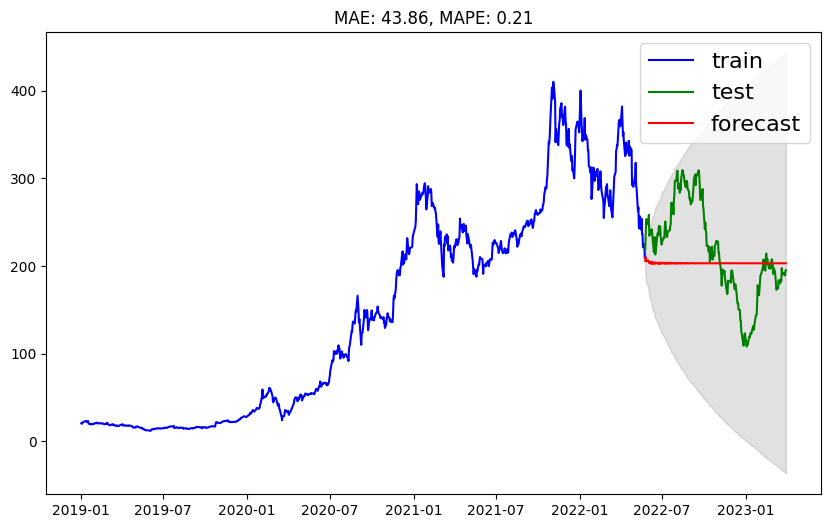

In [114]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

fh = np.arange(test_len) + 1
forecast = forecaster.predict(fh=fh)
coverage = 0.95
forecast_int = forecaster.predict_interval(fh=fh, coverage=coverage)['Coverage'][coverage]

TSLA_train.index = train_dates
forecast.index = TSLA_test.index

mae = np.round(mean_absolute_error(TSLA_test, forecast), 2)
mape = np.round(mean_absolute_percentage_error(TSLA_test, forecast), 2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TSLA_train.index, TSLA_train.values, label="train", color = 'b')
ax.plot(TSLA_test.index, TSLA_test.values, label="test", color = 'g')
ax.plot(forecast.index, forecast.values, label="forecast", color = 'r')
ax.fill_between(TSLA_test.index, 
                forecast_int["lower"],
                forecast_int["upper"],
                alpha=0.2, 
                color="dimgray")

ax.set_title(f'MAE: {mae}, MAPE: {mape}')
plt.legend(prop={'size':16})
plt.savefig("output/scikit-learn04.png", dpi=200)
plt.show()

## LightGBM

In [27]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

C:\Users\j2hoo\OneDrive\Documents\streamlitbook-evansarah\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [31]:
def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid, 
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape

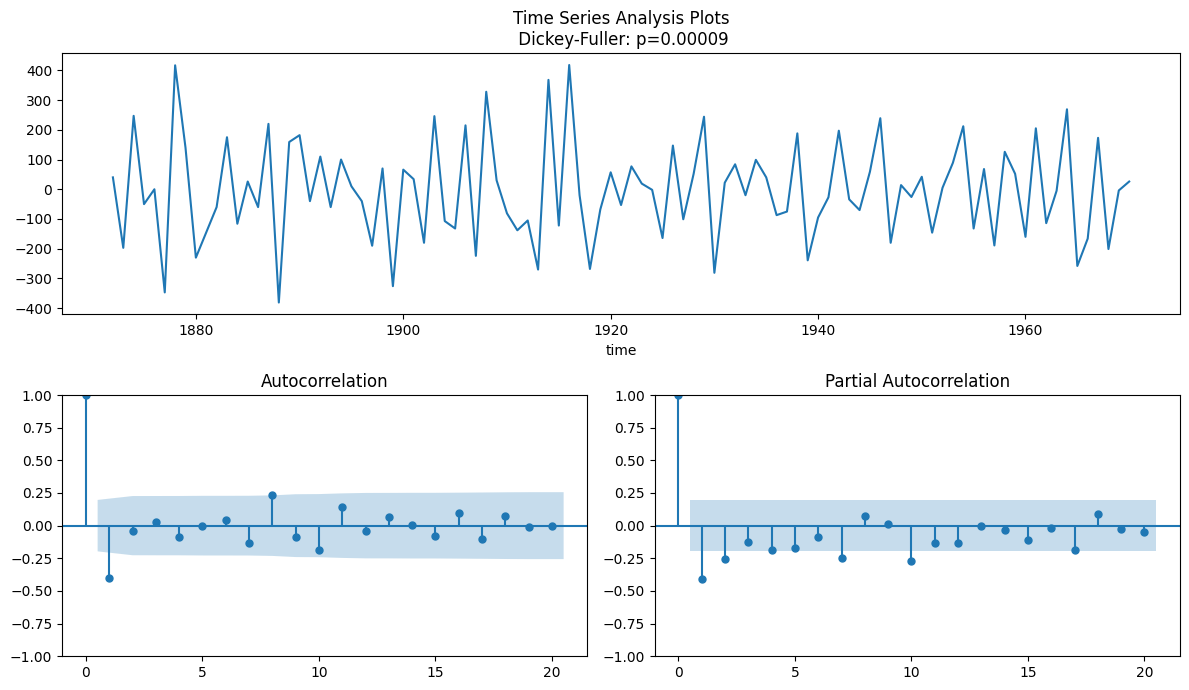

In [32]:
ts_nl = sm.datasets.get_rdataset("Nile").data
ts_nl = ts_nl.set_index('time').value
ts_nl_diff = (ts_nl - ts_nl.shift(1)).dropna()
tsplot(ts_nl_diff)

best params: {'window_length': 6}


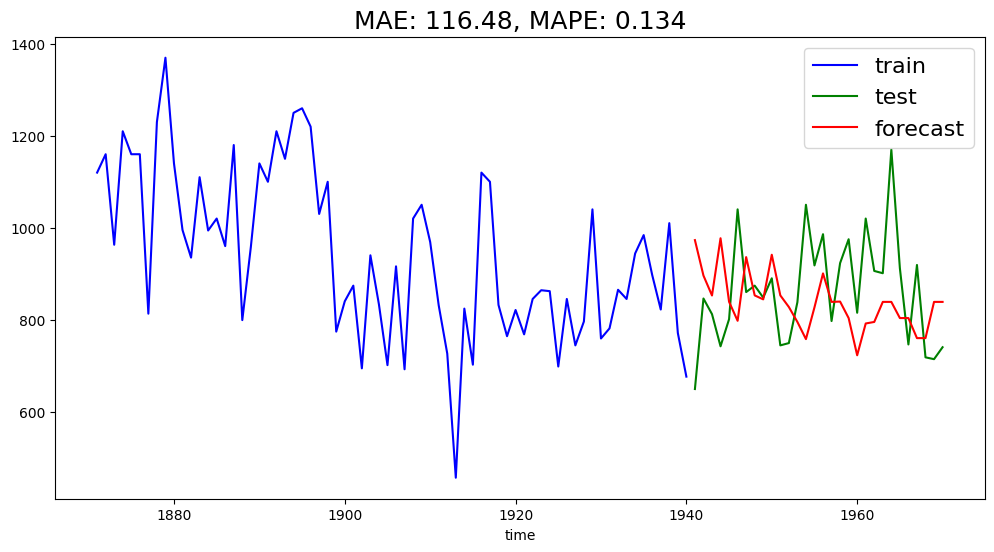

In [33]:
test_len = int(len(ts_nl) * 0.3)
nl_train, nl_test = ts_nl.iloc[:-test_len], ts_nl.iloc[-test_len:]
param_grid = {"window_length": [6, 12]}
forecaster = create_forecaster()
nl_lgb_mae, nl_lgb_mape = grid_serch_forecaster(
    nl_train, nl_test, forecaster, param_grid
)

In [34]:
pd.DataFrame(
    {"MAE": [nl_lgb_mae], "MAPE": [nl_lgb_mape]},
    index=["LightGBM"],
)

,MAE,MAPE
LightGBM,116.483759,0.133796


## Prophet

In [115]:
from prophet import Prophet
import statsmodels.api as sm
airline_df = sm.datasets.get_rdataset("Nile").data
airline_df = airline_df.set_index('time').value
airline_df

time
1871    1120
1872    1160
1873     963
1874    1210
1875    1160
        ... 
1966     746
1967     919
1968     718
1969     714
1970     740
Name: value, Length: 100, dtype: int64

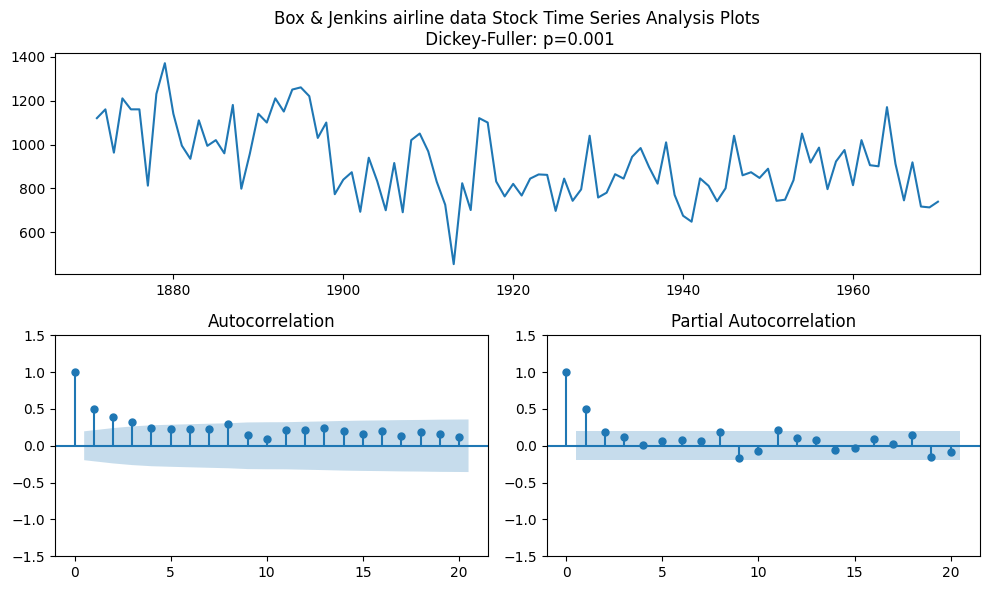

In [116]:
tsplot(airline_df, tickerName = "Box & Jenkins airline data", outputname = 'output/scikit-learn05.png')

In [117]:
test_len = int(len(airline_df) * 0.3)
train, test = ts_al.iloc[:-test_len], ts_al.iloc[-test_len:]
train.shape, test.shape

((114,), (30,))

In [118]:
train_pp = train.to_timestamp(freq="M").reset_index()
train_pp.columns = ["ds", "y"]
train_pp.head()

,ds,y
0,1949-01-31,112.0
1,1949-02-28,118.0
2,1949-03-31,132.0
3,1949-04-30,129.0
4,1949-05-31,121.0


In [119]:
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
model.fit(train_pp)

future = model.make_future_dataframe(periods=test_len, freq="M")
forecast = model.predict(future)
forecast = forecast.iloc[-test_len:]
forecast = forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"})
forecast.head()

23:10:05 - cmdstanpy - INFO - Chain [1] start processing
23:10:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,lower,upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
114,1958-07-31,397.460432,480.575608,503.867597,397.459733,397.460432,0.239731,0.239731,0.239731,0.239731,0.239731,0.239731,0.0,0.0,0.0,492.744040
115,1958-08-31,400.331253,471.239889,495.688885,400.279446,400.377410,0.208316,0.208316,0.208316,0.208316,0.208316,0.208316,0.0,0.0,0.0,483.726509
116,1958-09-30,403.109468,416.086766,439.598685,402.979970,403.228980,0.060466,0.060466,0.060466,0.060466,0.060466,0.060466,0.0,0.0,0.0,427.484003
117,1958-10-31,405.980290,360.716519,383.522791,405.754896,406.213863,-0.084357,-0.084357,-0.084357,-0.084357,-0.084357,-0.084357,0.0,0.0,0.0,371.732812
118,1958-11-30,408.758505,312.308918,335.623983,408.411603,409.110153,-0.206039,-0.206039,-0.206039,-0.206039,-0.206039,-0.206039,0.0,0.0,0.0,324.538351


In [120]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 114 to 143
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          30 non-null     datetime64[ns]
 1   trend                       30 non-null     float64       
 2   lower                       30 non-null     float64       
 3   upper                       30 non-null     float64       
 4   trend_lower                 30 non-null     float64       
 5   trend_upper                 30 non-null     float64       
 6   multiplicative_terms        30 non-null     float64       
 7   multiplicative_terms_lower  30 non-null     float64       
 8   multiplicative_terms_upper  30 non-null     float64       
 9   yearly                      30 non-null     float64       
 10  yearly_lower                30 non-null     float64       
 11  yearly_upper                30 non-null     float64      

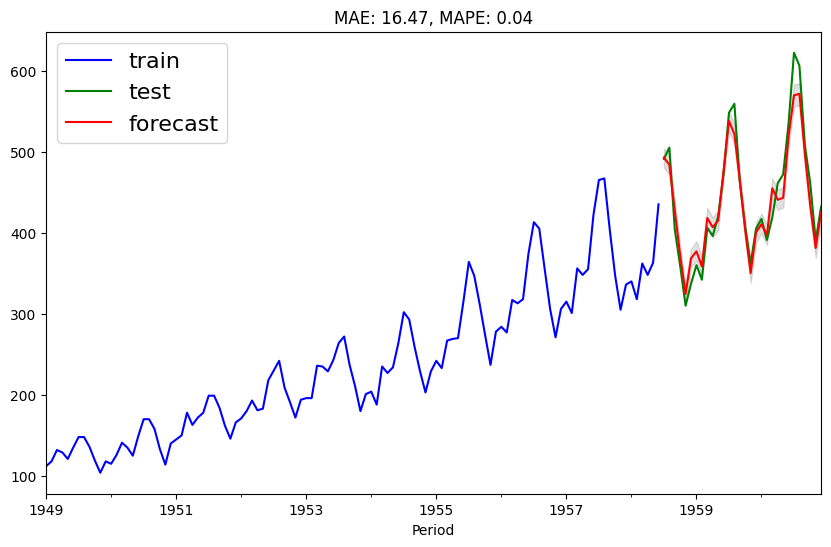

In [121]:
forecast.index = test.index

mae = np.round(mean_absolute_error(test, forecast['yhat']), 2)
mape = np.round(mean_absolute_percentage_error(test, forecast['yhat']), 2)

fig, ax = plt.subplots(figsize=(10, 6))
train.plot(label='train', color = 'b', ax=ax)
test.plot(label='test', color = 'g', ax=ax)

ax.plot(forecast["yhat"].index, forecast["yhat"].values, label="forecast", color = 'r')
ax.fill_between(test.index, 
                forecast["lower"],
                forecast["upper"],
                alpha=0.2, 
                color="dimgray")

ax.set_title(f'MAE: {mae}, MAPE: {mape}')
plt.legend(prop={'size':16})
plt.savefig("output/scikit-learn06.png", dpi=200)
plt.show()